<h2> NLP Classification - Toxic comment detection system </h2>

In this notebook we'll study how to make a Toxic comment detection system based on NLP classification using different methods such as Naive Baye, LSTM and transformers (Bert in particular).

<h3> Introduction - Quick Data exploration </h3>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
!pip install kaggle

%cd /content/gdrive/MyDrive/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/gdrive/MyDrive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/"

In [4]:
#!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

 98% 709M/723M [00:24<00:00, 28.1MB/s]
100% 723M/723M [00:24<00:00, 30.8MB/s]


In [4]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 28.0 MB/s 


In [5]:
import os
import re
import nltk
import unidecode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split

LIST_LABEL = ["severe_toxicity", "obscene", "identity_attack", "insult", "threat"]
data = pd.read_csv(os.path.join("train.csv"))

data.drop(columns=['target', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'], inplace=True)

data = data.iloc[:100000,:]
data['normal'] = (data.iloc[:, 2::].max(axis=1) == 0)
data['label'] = (data.iloc[:, 2::] >= 0.5).idxmax(1)
data.drop(columns=['normal'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               100000 non-null  int64  
 1   comment_text     100000 non-null  object 
 2   severe_toxicity  100000 non-null  float64
 3   obscene          100000 non-null  float64
 4   identity_attack  100000 non-null  float64
 5   insult           100000 non-null  float64
 6   threat           100000 non-null  float64
 7   normal           100000 non-null  bool   
 8   label            100000 non-null  object 
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 6.2+ MB


In [6]:
print('Number of NaN values:\n' + str(data.isnull().sum()))

Number of NaN values:
id                 0
comment_text       0
severe_toxicity    0
obscene            0
identity_attack    0
insult             0
threat             0
normal             0
label              0
dtype: int64


In [7]:
print(data['label'].value_counts(normalize=True)*100)

normal             73.765
severe_toxicity    20.324
insult              4.510
obscene             0.694
identity_attack     0.458
threat              0.249
Name: label, dtype: float64


<h3> Part I - Naive Baye Classification (One vs Rest): </h3>

train len: 85000
test len: 15000

Model 1 label: severe_toxicity
Recall: 0.8505564387917329
Specificity: 0.3847163004263693

Model 2 label: obscene
Recall: 0.9938238453276047
Specificity: 0.21153846153846154

Model 3 label: identity_attack
Recall: 0.9835242113723126
Specificity: 0.4057971014492754

Model 4 label: insult
Recall: 0.9615330913152751
Specificity: 0.46005917159763315

Model 5 label: threat
Recall: 0.9955891198289113
Specificity: 0.13513513513513514

Final model :


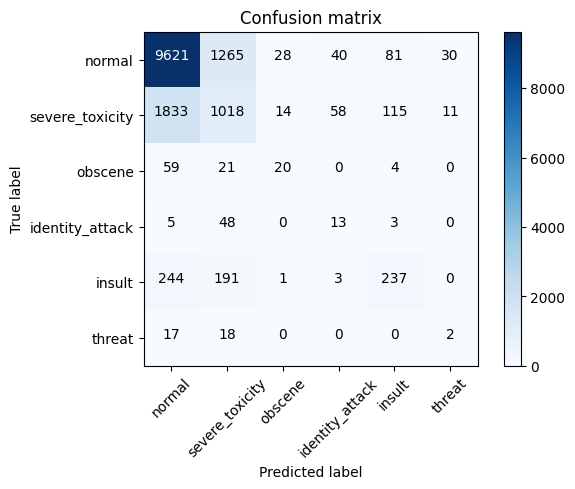

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def NB_text_processing(text):
    ''' Return cleaned text for Machine Learning '''
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    NEW_LINE = re.compile('\n')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(nltk.corpus.stopwords.words('english'))
    STEMMER = SnowballStemmer('english')

    text = text.lower()
    text = unidecode.unidecode(text)
    text = NEW_LINE.sub(' ',text)
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    text = BAD_SYMBOLS_RE.sub('',text)
    text = ' '.join([STEMMER.stem(word) for word in text.split() if word not in STOPWORDS])
    return text

def NB_preprocessing_OneVSR(data):
    ''' Return train and test set '''
    X = data['comment_text'].tolist()
    X = [NB_text_processing(txt) for txt in X]
    cv = CountVectorizer(max_features = 5000)
    X = cv.fit_transform(X).toarray()
    Y = data['label'].tolist()
    
    x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.15,train_size=0.85, stratify=data['label'].values)
    print('train len:', len(x_train))
    print('test len:', len(x_test))

    return x_train, x_test, y_train, y_test

def NB_Model_OneVSR(x_train, x_test, y_train, y_test, labelName):
    ''' Create a model based on Naive Bayes '''
    Y = []
    for i in range(len(y_train)):
        if(y_train[i] == labelName):
            Y.append(1)
        else:
            Y.append(0)
    Y2 = []
    for i in range(len(y_test)):
        if(y_test[i] == labelName):
            Y2.append(1)
        else:
            Y2.append(0)
    model = MultinomialNB()
    model.fit(x_train, Y)
    
    y_pred = model.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(Y2, y_pred).ravel()
    specificity = tp / (tp+fn)
    recall = tn / (tn+fp)
    print('Recall:', recall)
    print('Specificity:', specificity)
    return model

def NB_Train_OneVSR(x_train, x_test, y_train, y_test):
    tab_models = []; tab_proba = []
    for i in range(len(LIST_LABEL)):
        print('\nModel ' + str(i+1) + ' label: ' + LIST_LABEL[i])
        tab_models.append(NB_Model_OneVSR(x_train, x_test, y_train, y_test, LIST_LABEL[i]))
        tmp = []
        for proba in tab_models[i].predict_proba(x_test):
            tmp.append(proba[1])
        tab_proba.append(tmp)
    print('\nFinal model :')
    pred = []
    for i in range(len(x_test)):
        maxProba = 0; label = 'normal'
        for y in range(len(tab_proba)):
            if(maxProba < tab_proba[y][i]):
                maxProba = tab_proba[y][i]
                label = LIST_LABEL[y]
        if(maxProba < 0.5): label = 'normal'
        pred.append(label)
    
    cm = confusion_matrix(y_test, pred, labels=['normal']+LIST_LABEL)
    plot_confusion_matrix(cm, classes=['normal']+LIST_LABEL)
        
x_train, x_test, y_train, y_test = NB_preprocessing_OneVSR(data)
NB_Train_OneVSR(x_train, x_test, y_train, y_test)

We have:
* 81.68% accuracy for normal data
* 39.75% accuracy for toxic data
* 31.75% accuracy for obscene data
* 53.86% accuracy for insults

Which is pretty bad.


<h3> Part I (b) - Naive Baye Classification: </h3>

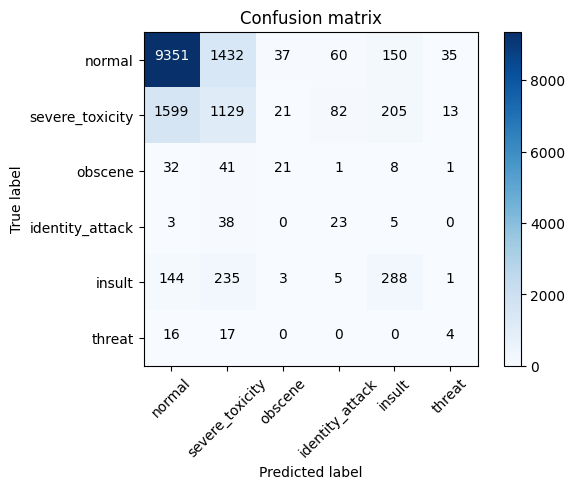

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

def NB_Model(x_train, x_test, y_train, y_test):
    ''' Create a model based on Naive Bayes '''
    classifier = MultinomialNB()
    classifier.fit(x_train, y_train)

    y_pred = classifier.predict(x_test)
    cm = confusion_matrix(y_test, y_pred, labels=['normal']+LIST_LABEL)
    plot_confusion_matrix(cm, classes=['normal']+LIST_LABEL)

NB_Model(x_train, x_test, y_train, y_test)

del x_train; del x_test; del y_train; del y_test

The accuracy doesn't vary much between the one versus rest and the naive bayes algorithm.

<h3> Part II - LSTM Classification: </h3>

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def NB_text_processing(text):
    ''' Return cleaned text for Machine Learning '''
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    NEW_LINE = re.compile('\n')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(nltk.corpus.stopwords.words('english'))
    STEMMER = SnowballStemmer('english')

    text = text.lower()
    text = unidecode.unidecode(text)
    text = NEW_LINE.sub(' ',text)
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    text = BAD_SYMBOLS_RE.sub('',text)
    text = ' '.join([STEMMER.stem(word) for word in text.split() if word not in STOPWORDS])
    return text

X = data['comment_text'].apply(lambda x: NB_text_processing(x))
Y = data['label'].tolist()
encoder = OneHotEncoder(sparse=False)
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1))

c=[]
for i in range(len(X)):
    m=len(X[i].split())
    c.append(m)
print('Maximum length of a sentence is : ',max(c))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

X = pad_sequences(tokenizer.texts_to_sequences(X), maxlen = max(c))
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.15,train_size=0.85)

Maximum length of a sentence is :  179
Vocabulary Size : 66835


In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

''' You have to download this file: http://nlp.stanford.edu/data/glove.6B.zip
    his weight is 1GO !'''

EMBEDDING_DIM = 300
BATCH_SIZE = 32

embeddings_index = {}

f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(vocab_size
    , EMBEDDING_DIM
    , weights=[embedding_matrix]
    , input_length=max(c)
    , trainable=False)

Found 400000 word vectors.


In [ ]:
import tensorflow as tf

def MakeModel():
    sequence_input = Input(shape=(max(c),), dtype='int32')
    embedding_sequences = embedding_layer(sequence_input)
    x = SpatialDropout1D(0.2)(embedding_sequences)
    x = Conv1D(64, 5, activation='relu')(x)
    x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(len(LIST_LABEL)+1, activation='softmax')(x)
    model = Model(sequence_input, outputs)
    print(model.summary())
    return model

model = MakeModel()
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 179)]             0         
                                                                 
 embedding (Embedding)       (None, 179, 300)          20050500  
                                                                 
 spatial_dropout1d (SpatialD  (None, 179, 300)         0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 175, 64)           96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048 

In [ ]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=4, validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau, model_checkpoint_callback])

Epoch 1/4
2657/2657 [==============================] - 337s 126ms/step - loss: 0.6609 - accuracy: 0.7517 - val_loss: 0.6089 - val_accuracy: 0.7606 - lr: 0.0010
Epoch 2/4
2657/2657 [==============================] - 331s 125ms/step - loss: 0.6020 - accuracy: 0.7666 - val_loss: 0.6091 - val_accuracy: 0.7694 - lr: 0.0010
Epoch 3/4
2657/2657 [==============================] - 338s 127ms/step - loss: 0.5765 - accuracy: 0.7736 - val_loss: 0.5883 - val_accuracy: 0.7726 - lr: 0.0010
Epoch 4/4
2657/2657 [==============================] - 337s 127ms/step - loss: 0.5557 - accuracy: 0.7803 - val_loss: 0.5976 - val_accuracy: 0.7678 - lr: 0.0010


469/469 [==============================] - 11s 22ms/step


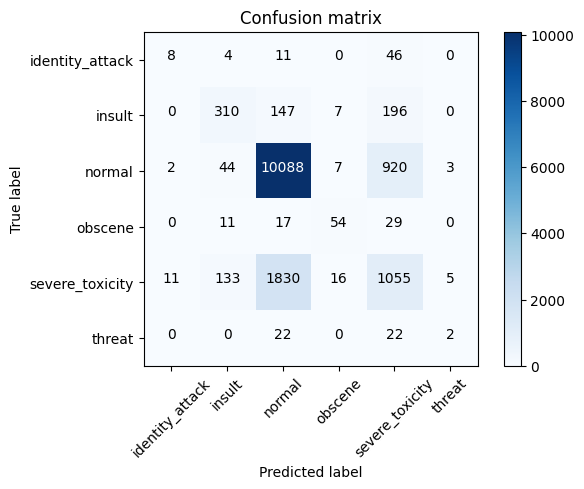

In [ ]:
y_tmp = model.predict(x_test)
y_pred = []
y_test2 = []
labels = []
for label in encoder.get_feature_names_out():
    labels.append(label[3:])
for i in range(len(y_tmp)):
    y_pred.append(str(np.argmax(y_tmp[i])))
for i in range(len(y_test)):
    y_test2.append(str(np.argmax(y_test[i])))
cm = confusion_matrix(y_test2, y_pred)
plot_confusion_matrix(cm, classes=labels)

We have:
* 83.27% accuracy for normal data
* 46.52% accuracy for toxic data
* 64.29% accuracy for obscene data
* 61.75% accuracy for insults

This is a great improvement from Naive Bayes.



<h3> Part III - Bert Classification: </h3>

In [8]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 32.6 MB/s 
     |████████████████████████████████| 6.6 MB 59.2 MB/s 
     |████████████████████████████████| 120 kB 73.5 MB/s 


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def Bert_preprocess_text(text, device, tokenizer):
    ''' Split text in chunks of 'delta' words strictly then encode it'''
    parts = []
    text_len = len(text.split(' '))
    delta = 200
    max_parts = 5
    nb_cuts = int(text_len / delta)
    nb_cuts = min(nb_cuts, max_parts)
    
    for i in range(nb_cuts + 1):
        text_part = ' '.join(text.split(' ')[i * delta: (i + 1) * delta])
        parts.append(tokenizer.encode(text_part, return_tensors="pt", max_length=500).to(device))

    return parts

def Bert_train_epoch(model, x_train, y_train, optimizer, device, tokenizer):
    ''' Train Bert model for one epoch '''
    print_every = 300; total_loss = 0
    all_losses = []
    model.train()
    correct_predictions = 0
    for idx in range(len(x_train)):
        text_parts = Bert_preprocess_text(x_train[idx], device, tokenizer)
        label = torch.tensor([y_train[idx]]).long().to(device)
        overall_output = torch.zeros(len(LIST_LABEL)+1).float().to(device)
        for part in text_parts:
            if len(part) > 0:
                try:
                    input = part.reshape(-1)[:512].reshape(1, -1)
                    overall_output = (model(input, labels=label)[1].float().to(device))[0]
                except Exception as e:
                    print(str(e))
        correct_predictions += (np.argmax(overall_output.cpu().detach().numpy()) == label).item()
        loss = model(input, labels=label)[0]
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if idx % print_every == 0 and idx > 0:
            average_loss = total_loss / print_every
            print("{}/{}. Average loss: {} | Accuracy: {}%".format(idx, len(x_train), average_loss, (correct_predictions/idx)*100))
            all_losses.append(average_loss)
            total_loss = 0
            
def Bert_eval_model(model, x_val, y_val, device, tokenizer):
    ''' Evaluate Bert model on validation data '''
    total_loss = 0; all_losses = []
    model.eval()
    correct_predictions = 0
    with torch.no_grad():
        for idx in range(len(x_val)):
            text_parts = Bert_preprocess_text(x_val[idx], device, tokenizer)
            label = torch.tensor([y_val[idx]]).long().to(device)
            overall_output = torch.zeros(len(LIST_LABEL)+1).float().to(device)
            for part in text_parts:
                if len(part) > 0:
                    try:
                        input = part.reshape(-1)[:512].reshape(1, -1)
                        overall_output += (model(input, labels=label)[1].float().to(device))[0]
                    except Exception as e:
                        print(str(e))
            correct_predictions += (np.argmax(overall_output.cpu().detach().numpy()) == label).item()
            loss = model(input, labels=label)[0]
            total_loss += loss.item()
        average_loss = total_loss / len(x_val)
        print("Average val loss: {} | Val accuracy: {}%".format(average_loss, (correct_predictions/len(x_val))*100))
        all_losses.append(average_loss)
        total_loss = 0
    

def Bert_train_model(X, Y):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    x, x_test, y, y_test = train_test_split(X,Y,test_size=0.05,train_size=0.95)
    x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.15,train_size=0.85)
    
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = len(LIST_LABEL)+1, output_attentions=False, output_hidden_states=False)
    for param in model.parameters():
        param.requires_grad = False #Freeze Bert !
    model.classifier = nn.Sequential(
        nn.Linear(model.config.hidden_size, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, len(LIST_LABEL)+1)
    )
    model = model.to(device)
    
    optimizer = optim.AdamW(model.classifier.parameters(), lr=3e-5)
    
    EPOCHS = 2
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')
        print('-' * 10)
        Bert_train_epoch(model, x_train, y_train, optimizer, device, tokenizer)
        Bert_eval_model(model, x_val, y_val, device, tokenizer)
        
X = data['comment_text'].tolist()
Y = data['label'].tolist()
le = LabelEncoder()
Y = le.fit_transform(Y)
Bert_train_model(X, Y)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Epoch 1/3
----------
300/80750. Average loss: 1.192623663296302 | Accuracy: 71.0%
600/80750. Average loss: 0.7387268683065971 | Accuracy: 74.16666666666667%
900/80750. Average loss: 0.816118637174368 | Accuracy: 73.88888888888889%
1200/80750. Average loss: 0.7741640907029311 | Accuracy: 73.83333333333333%
1500/80750. Average loss: 0.7169837466875713 | Accuracy: 74.53333333333333%
1800/80750. Average loss: 0.8487594232459863 | Accuracy: 73.94444444444444%
2100/80750. Average loss: 0.8222545349597931 | Accuracy: 74.0%
2400/80750. Average loss: 0.6934856360157331 | Accuracy: 74.125%
2700/80750. Average loss: 0.7659838400284449 | Accuracy: 74.29629629629629%
3000/80750. Average loss: 0.7930814652641615 | Accuracy: 73.93333333333332%
3300/80750. Average loss: 0.8338660921653112 | Accuracy: 73.72727272727273%
3600/80750. Average loss: 0.8363769850631555 | Accuracy: 73.47222222222223%
3900/80750. Average loss: 0.7289566302299499 | Accuracy: 73.56410256410257%
4200/80750. Average loss: 0.7729